## Undersampler Pipeline random forest with just excluding features

In [16]:
#start with all dependencies
%matplotlib inline
import numpy as np
import pandas as pd
from Evaluation import *
import sklearn
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import Imputer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import imblearn
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Read in the data as pandas dataframe
data = 'Statcast_data.csv'

def load_data(file):
    '''Load the Statcast_data.csv file into a pandas dataframe.
       Resolve unnecessary column in csv file'''
    baseball = pd.read_csv('Statcast_data.csv', index_col = 0)
    
    return baseball

baseball = load_data(data)
baseball['description'] = baseball['description'].replace({'blocked_ball': 0, 'ball': 0, "called_strike": 1})

baseball = baseball.dropna()

In [3]:
baseball.head()

,player_name,p_throws,pitch_name,release_speed,release_spin_rate,release_pos_x,release_pos_y,release_pos_z,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,release_extension,description
0,Chris Sale,L,2-Seam Fastball,95.1,2314.0,3.2655,54.4995,5.2575,1.7213,0.4271,-9.8035,-138.1130,0.1339,23.9464,31.0012,-27.0426,3.2971,1.5059,6.001,0
1,Chris Sale,L,4-Seam Fastball,96.7,2324.0,3.1728,54.3094,5.3966,0.9349,1.0015,-9.0084,-140.5865,-2.4218,14.3766,32.1373,-18.6501,3.3136,1.5730,6.191,1
2,Chris Sale,L,Slider,80.8,2521.0,3.3517,55.0820,5.1205,-1.0168,-0.1223,-3.7285,-117.3223,1.2140,-8.2088,25.0797,-33.8129,3.9119,1.7080,5.420,1
3,Chris Sale,L,4-Seam Fastball,96.2,2329.0,3.1334,54.0207,5.2136,1.3175,0.9402,-12.0533,-139.3669,-5.1407,20.1652,36.1370,-18.9205,3.5553,1.5639,6.479,1
4,Chris Sale,L,4-Seam Fastball,96.5,2437.0,3.3033,54.3597,5.0589,1.2794,0.7425,-14.0287,-139.8559,-3.3434,19.7342,30.0266,-21.9652,3.3450,1.6241,6.141,0


## Feature Creation
1. posx + movementx, posz +movementz
2. difference in the top of the zone and the position of the ball
    - any negative value will mean the ball is above the zone. 
4. difference in the position of the ball and the bottom of the zone. 
    - Any negative value will mean the ball is in the zone. 
3. compare to target

In [4]:
baseball['position_x'] = baseball['release_pos_x'] + baseball['pfx_x']
baseball['position_z'] = baseball['release_pos_z'] + baseball['pfx_z']

#baseball['difference_top_of_zone'] = baseball['sz_top'] - baseball['position_z']
#baseball['difference_bottom_of_zone'] = baseball['position_z'] - baseball['sz_top']
#baseball['difference_side_of_plate_x'] = baseball['']
#baseball['area_of_zone'] = 17 * baseball['height_of_zone']

In [5]:
baseball.columns

Index(['player_name', 'p_throws', 'pitch_name', 'release_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top',
       'sz_bot', 'release_extension', 'description', 'position_x',
       'position_z'],
      dtype='object')

In [7]:
final_df = baseball.loc[:, ['p_throws', 'pitch_name',
       'release_spin_rate', 'position_x', 'position_z',
        'vx0', 'vy0', 'vz0',  'sz_top',
       'sz_bot',]]

final_df=pd.get_dummies(final_df, prefix = 'pitch')
final_df.head()

,release_spin_rate,position_x,position_z,vx0,vy0,vz0,sz_top,sz_bot,pitch_L,pitch_R,pitch_2-Seam Fastball,pitch_4-Seam Fastball,pitch_Changeup,pitch_Curveball,pitch_Cutter,pitch_Eephus,pitch_Knuckle Curve,pitch_Sinker,pitch_Slider,pitch_Split Finger
0,2314.0,4.9868,5.6846,-9.8035,-138.1130,0.1339,3.2971,1.5059,1,0,1,0,0,0,0,0,0,0,0,0
1,2324.0,4.1077,6.3981,-9.0084,-140.5865,-2.4218,3.3136,1.5730,1,0,0,1,0,0,0,0,0,0,0,0
2,2521.0,2.3349,4.9982,-3.7285,-117.3223,1.2140,3.9119,1.7080,1,0,0,0,0,0,0,0,0,0,1,0
3,2329.0,4.4509,6.1538,-12.0533,-139.3669,-5.1407,3.5553,1.5639,1,0,0,1,0,0,0,0,0,0,0,0
4,2437.0,4.5827,5.8014,-14.0287,-139.8559,-3.3434,3.3450,1.6241,1,0,0,1,0,0,0,0,0,0,0,0


In [8]:
print(final_df.columns)

Index(['release_spin_rate', 'position_x', 'position_z', 'vx0', 'vy0', 'vz0',
       'sz_top', 'sz_bot', 'pitch_L', 'pitch_R', 'pitch_2-Seam Fastball',
       'pitch_4-Seam Fastball', 'pitch_Changeup', 'pitch_Curveball',
       'pitch_Cutter', 'pitch_Eephus', 'pitch_Knuckle Curve', 'pitch_Sinker',
       'pitch_Slider', 'pitch_Split Finger'],
      dtype='object')


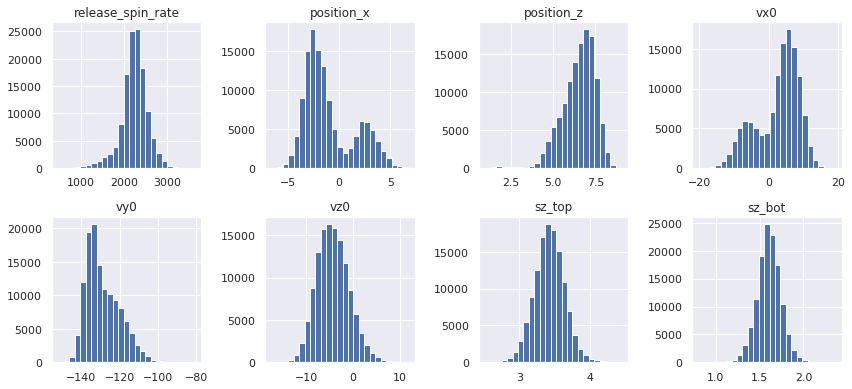

In [19]:
fig = plt.figure(figsize = (12, 8))
for idx, feature in enumerate(final_df.columns[:8]):
    idx+=1
    plt.subplot(3,4, idx, title = feature )
    plt.hist(final_df[feature], bins = 25)
    idx +=1
    plt.tight_layout()

## Simple Random Forest, to evaluatate new features

In [9]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split

Accuracy Score: 0.835699604743083

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.85      0.88     21552
           1       0.71      0.81      0.76     10073

    accuracy                           0.84     31625
   macro avg       0.81      0.83      0.82     31625
weighted avg       0.84      0.84      0.84     31625


 Confustion Matrix: 
 [[18271  3281]
 [ 1915  8158]]


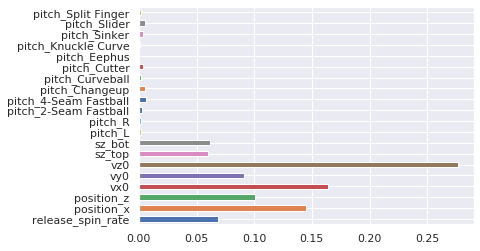

In [10]:
X_train, X_test, y_train, y_test = train_test_split(final_df,
                                                    baseball['description'], random_state = 777)
under_sampler = RandomUnderSampler(ratio = 1, random_state = 777)

forest = RandomForestClassifier()

pipe = imblearn.pipeline.make_pipeline(under_sampler,forest)



pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(pred, y_test)

pd.Series(pipe[1][2].feature_importances_, index=X_train.columns).plot(kind = 'barh')

## USE PCA

In [11]:

cv_results_lst = []
for n_components in [3,4,5,6]:
    print(f"Number of Components: {n_components}")
    print('-'*75)
    print()
    pca = PCA(n_components=n_components)
    forest = RandomForestClassifier(n_estimators=10)
    
    pipe = Pipeline(steps = [
        ('sampler', under_sampler), #RandomUnderSampler(ratio = 1, random_state = 777)
        ('pca', pca),
        ('forest', forest)
    ])
    
    cv_results = cross_validate(pipe, X_train, y_train, scoring = ['accuracy', 'f1', 'roc_auc'], 
                                cv =3, return_estimator=True, return_train_score = True)

    cv_results_lst.append(cv_results)
    for result in ['train_accuracy', 'test_accuracy', 'train_f1', 'test_f1', 'train_roc_auc', 'test_roc_auc']:
        print(f"Mean {result} Value: {np.mean(cv_results[result])}")
        print(f"{result} scores: {cv_results[result]}")
        print() 
    

    


Number of Components: 3
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.8501892027352422
train_accuracy scores: [0.8506514  0.85049566 0.84942054]

Mean test_accuracy Value: 0.5718275991250287
test_accuracy scores: [0.57201581 0.57402606 0.56944093]

Mean train_f1 Value: 0.805730123126156
train_f1 scores: [0.80621205 0.80611826 0.80486006]

Mean test_f1 Value: 0.4168679824852317
test_f1 scores: [0.41586466 0.41711739 0.4176219 ]

Mean train_roc_auc Value: 0.9465282848927278
train_roc_auc scores: [0.94634051 0.94759899 0.94564536]

Mean test_roc_auc Value: 0.5712459643320048
test_roc_auc scores: [0.57034546 0.57089213 0.5725003 ]

Number of Components: 4
---------------------------------------------------------------------------

Mean train_accuracy Value: 0.8795442360317326
train_accuracy scores: [0.88015431 0.87925501 0.87922339]

Mean test_accuracy Value: 0.6734476458732664
test_accuracy scores: [0.67494071 0.67081963 0.674582

In [12]:
cv_results_lst[3]['estimator'][0] #n_components of 6, as it performed best

Pipeline(memory=None,
         steps=[('sampler',
                 RandomUnderSampler(random_state=777, ratio=1,
                                    replacement=False, return_indices=False,
                                    sampling_strategy=1)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=6,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        

In [ ]:
forest_best = result.best_estimator_

predictions = forest_best.predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"AUC Score: {metrics.roc_auc_score(y_test, x_test_predictions)}")
    print()
    print(f"F1 Score: {metrics.f1_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

In [13]:
predictions = cv_results_lst[3]['estimator'][0].predict(X_test)

def eval_test_set(x_test_predictions, y_test):
    print(f"Accuracy Score: {metrics.accuracy_score(y_test, x_test_predictions)}")
    print()
    print(f"Classification Report: \n {metrics.classification_report(y_test, x_test_predictions)}")
    print()
    print(f" Confustion Matrix: \n {metrics.confusion_matrix(y_test, x_test_predictions)}")

eval_test_set(predictions, y_test)

Accuracy Score: 0.8904664031620554

Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.89      0.92     21552
           1       0.80      0.88      0.84     10073

    accuracy                           0.89     31625
   macro avg       0.87      0.89      0.88     31625
weighted avg       0.90      0.89      0.89     31625


 Confustion Matrix: 
 [[19265  2287]
 [ 1177  8896]]


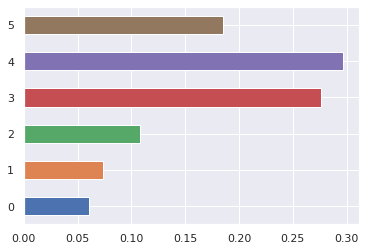

In [14]:
pd.Series(cv_results_lst[3]['estimator'][0][2].feature_importances_).plot(kind = 'barh')

In [14]:
pd.Series(cv_results_lst[3]['estimator'][0][1].explained_variance_ratio_)

0    0.998145
1    0.001302
2    0.000442
3    0.000082
4    0.000009
5    0.000004
dtype: float64